<a href="https://colab.research.google.com/github/emrekuruu/Fine-Tune/blob/main/knowledge_distil_roberta_vs_distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
!pip install transformers datasets peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
!pip install torch torchvision

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, TrainingArguments
from datasets import Dataset
import torch
import numpy as np
from sklearn.metrics import accuracy_score

In [5]:
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split

In [6]:
def prepare_datasets(tokenizer, dataset_name="financial_phrasebank", subset_name="sentences_50agree", max_length=128, random_state=42):
    dataset = load_dataset(dataset_name, subset_name, trust_remote_code=True)

    df = pd.DataFrame(dataset['train'])

    # Stratify split into train, validation, and test
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df['sentence'], df['label'], test_size=0.2, stratify=df['label'], random_state=random_state
    )
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_texts, train_labels, test_size=0.1, stratify=train_labels, random_state=random_state
    )

    # Create DataFrames for each split
    train_df = pd.DataFrame({'sentence': train_texts, 'label': train_labels})
    val_df = pd.DataFrame({'sentence': val_texts, 'label': val_labels})
    test_df = pd.DataFrame({'sentence': test_texts, 'label': test_labels})

    # Convert DataFrames to Hugging Face Dataset format
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_df)

    # Define tokenization function
    def tokenize_function(example):
        return tokenizer(
            example["sentence"],
            padding="max_length",
            truncation=True,
            max_length=max_length
        )
     # Tokenize datasets
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)

    # Remove raw text and prepare for Hugging Face Trainer
    train_dataset = train_dataset.remove_columns(["sentence"])
    val_dataset = val_dataset.remove_columns(["sentence"])
    test_dataset = test_dataset.remove_columns(["sentence"])

    train_dataset = train_dataset.rename_column("label", "labels")
    val_dataset = val_dataset.rename_column("label", "labels")
    test_dataset = test_dataset.rename_column("label", "labels")

    train_dataset.set_format("torch")
    val_dataset.set_format("torch")
    test_dataset.set_format("torch")

    return train_dataset, val_dataset, test_dataset

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the tokenizer for BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Load the Teacher model (BERT)
teacher_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Load the Student model (DistilBERT)
student_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset, val_dataset, test_dataset = prepare_datasets(tokenizer)

Map: 100%|██████████| 970/970 [00:00<00:00, 22919.05 examples/s]


In [ ]:
import torch
import torch.nn.functional as F

def distillation_loss(student_logits, teacher_logits, true_labels, temperature=2.0, alpha=0.7):
    # Soft labels from teacher model
    soft_labels = F.softmax(teacher_logits / temperature, dim=-1)

    # Hard loss using true labels
    hard_loss = F.cross_entropy(student_logits, true_labels)

    # Soft loss between teacher and student logits
    soft_loss = F.kl_div(
        F.log_softmax(student_logits / temperature, dim=-1),
        soft_labels,
        reduction='batchmean'
    )

    # Weighted combination of soft and hard loss
    return alpha * soft_loss + (1.0 - alpha) * hard_loss



In [ ]:
from torch.utils.data import DataLoader

def get_teacher_logits(model, dataset, batch_size=16, device='cpu'):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    logits = []

    model.eval()  # Set teacher model to evaluation mode
    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            outputs = model(**inputs)
            logits.append(outputs.logits.cpu())

    return torch.cat(logits, dim=0)  # Concatenate all logits into one tensor


In [ ]:
def distillation_train_loop(student_model, teacher_model, train_dataset, val_dataset, tokenizer, epochs=3, batch_size=16, learning_rate=5e-5, device='cpu'):
    student_model = student_model.to(device)
    teacher_model = teacher_model.to(device)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    optimizer = torch.optim.AdamW(student_model.parameters(), lr=learning_rate)

    # Teacher logits for the entire training dataset
    teacher_logits = get_teacher_logits(teacher_model, train_dataset, batch_size=batch_size, device=device)
    print(f"Teacher logits: {teacher_logits}")

    for epoch in range(epochs):
        student_model.train()
        total_loss = 0.0

        for i, batch in enumerate(train_dataloader):
            inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            labels = batch['labels'].to(device)

            # Select corresponding teacher logits for this batch
            batch_teacher_logits = teacher_logits[i * batch_size:(i + 1) * batch_size].to(device)

            # Forward pass of student model
            student_outputs = student_model(**inputs)
            print(f"Student outputs: {student_outputs}")
            student_logits = student_outputs.logits
            print(f"Student logits: {student_logits}")

            # Compute loss
            loss = distillation_loss(student_logits, batch_teacher_logits, labels)
            total_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dataloader):.4f}")

    return student_model



In [ ]:
# Set up the training arguments for the teacher model
training_args = TrainingArguments(
    output_dir="./results_knowledge_distill/teacher_model",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs_knowledge_distill/teacher_model",
    logging_steps=10,
)

# Trainer for the teacher model
trainer_teacher = Trainer(
    model=teacher_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Fine-tune the teacher model
trainer_teacher.train()


/Users/beyzakaya/miniforge3/envs/DLprojectenv/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/kv/563b5k8n4xg24_t9kd2d72c40000gn/T/ipykernel_56174/2655727639.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(
  2%|▏         | 10/654 [00:22<15:48,  1.47s/it] 

{'loss': 0.8957, 'grad_norm': 4.335817337036133, 'learning_rate': 4.923547400611621e-05, 'epoch': 0.05}


  3%|▎         | 20/654 [00:35<11:03,  1.05s/it]

{'loss': 0.7797, 'grad_norm': 3.726905584335327, 'learning_rate': 4.847094801223242e-05, 'epoch': 0.09}


  5%|▍         | 30/654 [00:55<19:18,  1.86s/it]

{'loss': 0.7911, 'grad_norm': 3.6768481731414795, 'learning_rate': 4.7706422018348626e-05, 'epoch': 0.14}


  6%|▌         | 40/654 [01:14<20:44,  2.03s/it]

{'loss': 0.7659, 'grad_norm': 6.559085845947266, 'learning_rate': 4.694189602446483e-05, 'epoch': 0.18}


  8%|▊         | 50/654 [01:34<14:28,  1.44s/it]

{'loss': 0.6494, 'grad_norm': 5.637365341186523, 'learning_rate': 4.617737003058104e-05, 'epoch': 0.23}


  9%|▉         | 60/654 [02:01<34:59,  3.54s/it]

{'loss': 0.5958, 'grad_norm': 7.2245049476623535, 'learning_rate': 4.541284403669725e-05, 'epoch': 0.28}


 11%|█         | 70/654 [02:44<33:00,  3.39s/it]  

{'loss': 0.5212, 'grad_norm': 9.817317008972168, 'learning_rate': 4.4648318042813456e-05, 'epoch': 0.32}


 12%|█▏        | 80/654 [03:20<37:59,  3.97s/it]

{'loss': 0.5809, 'grad_norm': 14.302302360534668, 'learning_rate': 4.3883792048929664e-05, 'epoch': 0.37}


 14%|█▍        | 90/654 [03:51<25:06,  2.67s/it]

{'loss': 0.4667, 'grad_norm': 4.403275012969971, 'learning_rate': 4.311926605504588e-05, 'epoch': 0.41}


 15%|█▌        | 100/654 [04:09<13:33,  1.47s/it]

{'loss': 0.4744, 'grad_norm': 2.98917293548584, 'learning_rate': 4.235474006116208e-05, 'epoch': 0.46}


 17%|█▋        | 110/654 [04:27<14:55,  1.65s/it]

{'loss': 0.4692, 'grad_norm': 13.180750846862793, 'learning_rate': 4.159021406727829e-05, 'epoch': 0.5}


 18%|█▊        | 120/654 [04:39<08:44,  1.02it/s]

{'loss': 0.451, 'grad_norm': 4.209173679351807, 'learning_rate': 4.0825688073394495e-05, 'epoch': 0.55}


 20%|█▉        | 130/654 [04:47<07:08,  1.22it/s]

{'loss': 0.3658, 'grad_norm': 13.522235870361328, 'learning_rate': 4.00611620795107e-05, 'epoch': 0.6}


 21%|██▏       | 140/654 [04:56<08:09,  1.05it/s]

{'loss': 0.4707, 'grad_norm': 6.981060981750488, 'learning_rate': 3.929663608562692e-05, 'epoch': 0.64}


 23%|██▎       | 150/654 [05:05<07:03,  1.19it/s]

{'loss': 0.394, 'grad_norm': 3.078388214111328, 'learning_rate': 3.8532110091743125e-05, 'epoch': 0.69}


 24%|██▍       | 160/654 [05:15<08:03,  1.02it/s]

{'loss': 0.4116, 'grad_norm': 11.815357208251953, 'learning_rate': 3.7767584097859326e-05, 'epoch': 0.73}


 26%|██▌       | 170/654 [05:26<07:30,  1.07it/s]

{'loss': 0.4293, 'grad_norm': 8.353646278381348, 'learning_rate': 3.7003058103975534e-05, 'epoch': 0.78}


 28%|██▊       | 180/654 [05:34<06:24,  1.23it/s]

{'loss': 0.4091, 'grad_norm': 3.852647542953491, 'learning_rate': 3.623853211009174e-05, 'epoch': 0.83}


 29%|██▉       | 190/654 [05:47<11:29,  1.48s/it]

{'loss': 0.3439, 'grad_norm': 8.242115020751953, 'learning_rate': 3.5474006116207956e-05, 'epoch': 0.87}


 31%|███       | 200/654 [05:57<07:18,  1.03it/s]

{'loss': 0.4478, 'grad_norm': 11.006133079528809, 'learning_rate': 3.4709480122324164e-05, 'epoch': 0.92}


 32%|███▏      | 210/654 [06:07<07:36,  1.03s/it]

{'loss': 0.4146, 'grad_norm': 3.8564493656158447, 'learning_rate': 3.394495412844037e-05, 'epoch': 0.96}


                                                 
 33%|███▎      | 218/654 [06:22<06:04,  1.20it/s]

{'eval_loss': 0.39951249957084656, 'eval_runtime': 7.9863, 'eval_samples_per_second': 48.583, 'eval_steps_per_second': 3.13, 'epoch': 1.0}


 34%|███▎      | 220/654 [06:25<20:41,  2.86s/it]

{'loss': 0.4293, 'grad_norm': 5.919196605682373, 'learning_rate': 3.318042813455658e-05, 'epoch': 1.01}


 35%|███▌      | 230/654 [06:35<06:36,  1.07it/s]

{'loss': 0.2745, 'grad_norm': 12.205646514892578, 'learning_rate': 3.241590214067278e-05, 'epoch': 1.06}


 37%|███▋      | 240/654 [06:44<05:46,  1.19it/s]

{'loss': 0.2492, 'grad_norm': 19.635948181152344, 'learning_rate': 3.1651376146788995e-05, 'epoch': 1.1}


 38%|███▊      | 250/654 [06:52<05:59,  1.12it/s]

{'loss': 0.2927, 'grad_norm': 13.9088716506958, 'learning_rate': 3.08868501529052e-05, 'epoch': 1.15}


 40%|███▉      | 260/654 [07:01<05:22,  1.22it/s]

{'loss': 0.2574, 'grad_norm': 12.238587379455566, 'learning_rate': 3.012232415902141e-05, 'epoch': 1.19}


 41%|████▏     | 270/654 [07:09<05:22,  1.19it/s]

{'loss': 0.2473, 'grad_norm': 4.494692802429199, 'learning_rate': 2.9357798165137618e-05, 'epoch': 1.24}


 43%|████▎     | 280/654 [07:18<05:12,  1.20it/s]

{'loss': 0.2933, 'grad_norm': 5.556410789489746, 'learning_rate': 2.8593272171253826e-05, 'epoch': 1.28}


 44%|████▍     | 290/654 [07:26<05:01,  1.21it/s]

{'loss': 0.2478, 'grad_norm': 15.016253471374512, 'learning_rate': 2.782874617737003e-05, 'epoch': 1.33}


 46%|████▌     | 300/654 [07:35<04:48,  1.23it/s]

{'loss': 0.2413, 'grad_norm': 10.48573112487793, 'learning_rate': 2.7064220183486238e-05, 'epoch': 1.38}


 47%|████▋     | 310/654 [07:43<04:30,  1.27it/s]

{'loss': 0.2933, 'grad_norm': 8.468277931213379, 'learning_rate': 2.629969418960245e-05, 'epoch': 1.42}


 49%|████▉     | 320/654 [07:51<04:33,  1.22it/s]

{'loss': 0.2082, 'grad_norm': 11.91784954071045, 'learning_rate': 2.5535168195718656e-05, 'epoch': 1.47}


 50%|█████     | 330/654 [08:00<04:21,  1.24it/s]

{'loss': 0.1717, 'grad_norm': 6.597239017486572, 'learning_rate': 2.4770642201834864e-05, 'epoch': 1.51}


 52%|█████▏    | 340/654 [08:08<04:10,  1.25it/s]

{'loss': 0.2109, 'grad_norm': 6.263698577880859, 'learning_rate': 2.4006116207951072e-05, 'epoch': 1.56}


 54%|█████▎    | 350/654 [08:16<04:01,  1.26it/s]

{'loss': 0.2668, 'grad_norm': 3.51605486869812, 'learning_rate': 2.324159021406728e-05, 'epoch': 1.61}


 55%|█████▌    | 360/654 [08:25<03:58,  1.23it/s]

{'loss': 0.2358, 'grad_norm': 6.929905891418457, 'learning_rate': 2.2477064220183487e-05, 'epoch': 1.65}


 57%|█████▋    | 370/654 [08:32<03:38,  1.30it/s]

{'loss': 0.1737, 'grad_norm': 13.150646209716797, 'learning_rate': 2.1712538226299695e-05, 'epoch': 1.7}


 58%|█████▊    | 380/654 [08:59<08:46,  1.92s/it]

{'loss': 0.1887, 'grad_norm': 2.7542884349823, 'learning_rate': 2.0948012232415903e-05, 'epoch': 1.74}


 60%|█████▉    | 390/654 [09:17<08:21,  1.90s/it]

{'loss': 0.2438, 'grad_norm': 7.993503093719482, 'learning_rate': 2.018348623853211e-05, 'epoch': 1.79}


 61%|██████    | 400/654 [09:43<07:55,  1.87s/it]

{'loss': 0.2273, 'grad_norm': 1.731151819229126, 'learning_rate': 1.9418960244648318e-05, 'epoch': 1.83}


 63%|██████▎   | 410/654 [09:51<03:25,  1.19it/s]

{'loss': 0.189, 'grad_norm': 10.786277770996094, 'learning_rate': 1.8654434250764526e-05, 'epoch': 1.88}


 64%|██████▍   | 420/654 [10:00<03:27,  1.13it/s]

{'loss': 0.2369, 'grad_norm': 24.436796188354492, 'learning_rate': 1.7889908256880737e-05, 'epoch': 1.93}


 66%|██████▌   | 430/654 [10:09<03:13,  1.15it/s]

{'loss': 0.2379, 'grad_norm': 10.953409194946289, 'learning_rate': 1.712538226299694e-05, 'epoch': 1.97}


                                                 
 67%|██████▋   | 436/654 [10:20<03:09,  1.15it/s]

{'eval_loss': 0.42221856117248535, 'eval_runtime': 5.1733, 'eval_samples_per_second': 75.001, 'eval_steps_per_second': 4.833, 'epoch': 2.0}


 67%|██████▋   | 440/654 [10:25<05:57,  1.67s/it]

{'loss': 0.1247, 'grad_norm': 0.48542287945747375, 'learning_rate': 1.636085626911315e-05, 'epoch': 2.02}


 69%|██████▉   | 450/654 [10:35<03:32,  1.04s/it]

{'loss': 0.1219, 'grad_norm': 4.878985404968262, 'learning_rate': 1.559633027522936e-05, 'epoch': 2.06}


 70%|███████   | 460/654 [10:44<02:38,  1.22it/s]

{'loss': 0.0529, 'grad_norm': 0.5471055507659912, 'learning_rate': 1.4831804281345565e-05, 'epoch': 2.11}


 72%|███████▏  | 470/654 [10:56<04:36,  1.50s/it]

{'loss': 0.094, 'grad_norm': 2.234342336654663, 'learning_rate': 1.4067278287461774e-05, 'epoch': 2.16}


 73%|███████▎  | 480/654 [11:10<03:11,  1.10s/it]

{'loss': 0.0941, 'grad_norm': 2.1173996925354004, 'learning_rate': 1.3302752293577984e-05, 'epoch': 2.2}


 75%|███████▍  | 490/654 [11:23<03:31,  1.29s/it]

{'loss': 0.1095, 'grad_norm': 8.039071083068848, 'learning_rate': 1.253822629969419e-05, 'epoch': 2.25}


 76%|███████▋  | 500/654 [11:50<09:03,  3.53s/it]

{'loss': 0.0603, 'grad_norm': 0.2917783856391907, 'learning_rate': 1.1773700305810397e-05, 'epoch': 2.29}


 78%|███████▊  | 510/654 [12:28<06:34,  2.74s/it]

{'loss': 0.058, 'grad_norm': 3.5893125534057617, 'learning_rate': 1.1009174311926607e-05, 'epoch': 2.34}


 80%|███████▉  | 520/654 [12:48<04:15,  1.90s/it]

{'loss': 0.0454, 'grad_norm': 0.35865363478660583, 'learning_rate': 1.0244648318042814e-05, 'epoch': 2.39}


 81%|████████  | 530/654 [12:58<01:46,  1.16it/s]

{'loss': 0.0929, 'grad_norm': 1.6767597198486328, 'learning_rate': 9.480122324159022e-06, 'epoch': 2.43}


 83%|████████▎ | 540/654 [13:06<01:33,  1.21it/s]

{'loss': 0.065, 'grad_norm': 0.4124130606651306, 'learning_rate': 8.71559633027523e-06, 'epoch': 2.48}


 84%|████████▍ | 550/654 [13:59<06:46,  3.91s/it]

{'loss': 0.1427, 'grad_norm': 7.561567783355713, 'learning_rate': 7.951070336391438e-06, 'epoch': 2.52}


 86%|████████▌ | 560/654 [14:19<03:21,  2.15s/it]

{'loss': 0.1231, 'grad_norm': 0.09226620942354202, 'learning_rate': 7.186544342507645e-06, 'epoch': 2.57}


 87%|████████▋ | 570/654 [14:48<03:34,  2.56s/it]

{'loss': 0.0902, 'grad_norm': 2.3611152172088623, 'learning_rate': 6.422018348623854e-06, 'epoch': 2.61}


 89%|████████▊ | 580/654 [15:07<02:04,  1.69s/it]

{'loss': 0.1019, 'grad_norm': 0.11030992120504379, 'learning_rate': 5.657492354740062e-06, 'epoch': 2.66}


 90%|█████████ | 590/654 [15:25<01:34,  1.47s/it]

{'loss': 0.0148, 'grad_norm': 0.17759627103805542, 'learning_rate': 4.892966360856269e-06, 'epoch': 2.71}


 92%|█████████▏| 600/654 [15:37<00:56,  1.05s/it]

{'loss': 0.127, 'grad_norm': 0.4788254201412201, 'learning_rate': 4.128440366972477e-06, 'epoch': 2.75}


 93%|█████████▎| 610/654 [16:06<01:00,  1.37s/it]

{'loss': 0.1061, 'grad_norm': 13.228991508483887, 'learning_rate': 3.363914373088685e-06, 'epoch': 2.8}


 95%|█████████▍| 620/654 [16:22<00:40,  1.19s/it]

{'loss': 0.1632, 'grad_norm': 16.87421417236328, 'learning_rate': 2.599388379204893e-06, 'epoch': 2.84}


 96%|█████████▋| 630/654 [16:33<00:28,  1.18s/it]

{'loss': 0.1102, 'grad_norm': 2.434553861618042, 'learning_rate': 1.8348623853211011e-06, 'epoch': 2.89}


 98%|█████████▊| 640/654 [16:47<00:24,  1.78s/it]

{'loss': 0.0989, 'grad_norm': 0.21832436323165894, 'learning_rate': 1.0703363914373088e-06, 'epoch': 2.94}


 99%|█████████▉| 650/654 [16:58<00:04,  1.02s/it]

{'loss': 0.1114, 'grad_norm': 0.08660129457712173, 'learning_rate': 3.0581039755351683e-07, 'epoch': 2.98}


                                                 
100%|██████████| 654/654 [17:20<00:00,  1.59s/it]

{'eval_loss': 0.6311530470848083, 'eval_runtime': 7.7797, 'eval_samples_per_second': 49.873, 'eval_steps_per_second': 3.213, 'epoch': 3.0}
{'train_runtime': 1040.5886, 'train_samples_per_second': 10.056, 'train_steps_per_second': 0.628, 'train_loss': 0.2857098263611487, 'epoch': 3.0}


TrainOutput(global_step=654, training_loss=0.2857098263611487, metrics={'train_runtime': 1040.5886, 'train_samples_per_second': 10.056, 'train_steps_per_second': 0.628, 'total_flos': 688304700776448.0, 'train_loss': 0.2857098263611487, 'epoch': 3.0})

#### This function ensures the student model is trained using the logits from the teacher model in addition to the ground truth labels, combining hard and soft losses.

In [ ]:
# Now, distill the knowledge into the student model
student_model = distillation_train_loop(student_model, teacher_model, train_dataset, val_dataset, tokenizer, epochs=3, batch_size=16)

Teacher logits: tensor([[-2.6213,  4.1635, -2.3194],
        [-1.5190, -1.7753,  4.8557],
        [-2.5256,  4.1303, -2.2848],
        ...,
        [-1.7173,  3.6361, -2.9695],
        [-1.8634, -1.4155,  4.7208],
        [-2.6480,  4.1266, -2.2814]])
Student outputs: SequenceClassifierOutput(loss=None, logits=tensor([[-1.4568,  1.6938, -0.6216],
        [-1.4918,  1.5309, -0.0303],
        [-1.6417,  1.1014,  0.4621],
        [-1.2778,  1.1750, -0.1223],
        [-1.7693,  0.3149,  1.4295],
        [-1.8186,  1.1852,  0.1105],
        [ 0.1959,  0.1122, -0.8044],
        [-2.2644,  0.2283,  1.6057],
        [-1.8654,  0.4816,  0.9782],
        [-0.0396,  0.2007, -0.8431],
        [-1.1631,  1.3751, -0.3029],
        [-1.7715,  1.5458,  0.2369],
        [-1.1664,  1.3201, -0.6355],
        [-1.6168, -0.0067,  1.1921],
        [-1.7620,  0.3772,  1.1147],
        [-1.8191,  1.2931,  0.3181]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
Student logits: tensor([[-1.456

#### After the student model is trained, HuggingFace Trainer is used for evaluation. evaluate() method in Trainer does not perform training again, it only uses the student model in evaluation mode

In [ ]:
trainer_student = Trainer(
    model=student_model,
    args=training_args,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

# Evaluate the student model
results = trainer_student.evaluate()
print(f"Evaluation Results: {results}")


/var/folders/kv/563b5k8n4xg24_t9kd2d72c40000gn/T/ipykernel_56174/4119820128.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_student = Trainer(
100%|██████████| 61/61 [00:07<00:00,  7.97it/s]

Evaluation Results: {'eval_loss': 0.5431520938873291, 'eval_model_preparation_time': 0.0042, 'eval_runtime': 8.9747, 'eval_samples_per_second': 108.081, 'eval_steps_per_second': 6.797}


In [ ]:
predictions = trainer_student.predict(test_dataset)

100%|██████████| 61/61 [00:07<00:00,  8.04it/s]


In [ ]:
import numpy as np

predicted_labels = np.argmax(predictions.predictions, axis=-1)

true_labels = predictions.label_ids

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

NameError: name 'true_labels' is not defined

#### Student model as ROBERTA student model as DISTILBERT

#### ROBERTA Robustly optimized BERT approach

In [10]:
from transformers import AutoTokenizer

# Initialize tokenizer and dataset
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_dataset, val_dataset, test_dataset = prepare_datasets(tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3488 [00:00<?, ? examples/s]

Map:   0%|          | 0/388 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [11]:
from transformers import AutoModelForSequenceClassification

teacher_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3).to(device)
student_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to(device)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
teacher_model = teacher_model.to(device)
student_model = student_model.to(device)

In [14]:
from transformers import TrainingArguments, Trainer
import os

os.environ["WANDB_DISABLED"] = "true"

training_args_teacher = TrainingArguments(
    output_dir="/content/results_knowledge_distill/teacher_model_ROBERTA",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="/content/logs_knowledge_distill/teacher_model_ROBERTA",
    logging_steps=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    save_total_limit=2,
    load_best_model_at_end=True,
    push_to_hub=False
)

trainer_teacher = Trainer(
    model=teacher_model,
    args=training_args_teacher,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer_teacher.train()

teacher_model.save_pretrained("/content/checkpoints/teacher_model_ROBERTA")


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-14-f8fe41ae71b8>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss
1,0.938400,0.926514
2,0.911400,0.926700
3,0.909500,0.857801


In [15]:
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def distillation_loss(student_logits, teacher_logits, true_labels, temperature, alpha):
    device = student_logits.device
    true_labels = true_labels.to(device)
    teacher_logits = teacher_logits.to(device)

    soft_labels = F.softmax(teacher_logits / temperature, dim=-1)

    hard_loss = F.cross_entropy(student_logits, true_labels)

    soft_loss = F.kl_div(
        F.log_softmax(student_logits / temperature, dim=-1),
        soft_labels,
        reduction="batchmean"
    )

    return alpha * soft_loss + (1 - alpha) * hard_loss


In [19]:
from torch.utils.data import DataLoader
from torch.optim import Adam

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

optimizer = Adam(student_model.parameters(), lr=2e-5)

In [20]:
import torch

epochs = 3
temperature = 2.0
alpha = 0.5

teacher_model.to("cuda")
teacher_model.eval()

for epoch in range(epochs):
    student_model.train()
    total_loss = 0.0

    for batch in train_dataloader:
        inputs = {k: v.to("cuda") for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
        labels = batch["labels"].to("cuda")

        # Get teacher logits (soft labels)
        with torch.no_grad():
            teacher_logits = teacher_model(**inputs).logits

        # Get student logits
        student_outputs = student_model(**inputs)
        student_logits = student_outputs.logits

        # Calculate distillation loss
        loss = distillation_loss(student_logits, teacher_logits, labels, temperature, alpha)
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dataloader)}")


Epoch 1/3, Loss: 0.3367614353058535
Epoch 2/3, Loss: 0.21890916695835394
Epoch 3/3, Loss: 0.17549574200850016


In [22]:
student_model.save_pretrained("/content/checkpoints/student_model")

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to("cuda") for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
            labels = batch["labels"].to("cuda")

            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, axis=-1).cpu().numpy()
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds)

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average="weighted")
    recall = recall_score(true_labels, predictions, average="weighted")
    f1 = f1_score(true_labels, predictions, average="weighted")
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

val_metrics = evaluate_model(student_model, val_dataloader)
print(f"Validation Metrics: {val_metrics}")


Validation Metrics: {'accuracy': 0.8530927835051546, 'precision': 0.8533877790196023, 'recall': 0.8530927835051546, 'f1': 0.8488220784681562}


In [23]:
!zip -r /content/checkpoints.zip /content/checkpoints

  adding: content/checkpoints/ (stored 0%)
  adding: content/checkpoints/teacher_model_ROBERTA/ (stored 0%)
  adding: content/checkpoints/teacher_model_ROBERTA/model.safetensors (deflated 16%)
  adding: content/checkpoints/teacher_model_ROBERTA/config.json (deflated 52%)
  adding: content/checkpoints/.ipynb_checkpoints/ (stored 0%)
  adding: content/checkpoints/student_model/ (stored 0%)
  adding: content/checkpoints/student_model/model.safetensors (deflated 8%)
  adding: content/checkpoints/student_model/config.json (deflated 47%)


In [24]:
!zip -r /content/logs_knowledge_distill.zip /content/logs_knowledge_distill

  adding: content/logs_knowledge_distill/ (stored 0%)
  adding: content/logs_knowledge_distill/teacher_model_ROBERTA/ (stored 0%)
  adding: content/logs_knowledge_distill/teacher_model_ROBERTA/events.out.tfevents.1735121717.9c95ddbc12f4.631.1 (deflated 66%)
  adding: content/logs_knowledge_distill/teacher_model_ROBERTA/events.out.tfevents.1735121576.9c95ddbc12f4.631.0 (deflated 62%)
  adding: content/logs_knowledge_distill/.ipynb_checkpoints/ (stored 0%)


In [25]:
!zip -r /content/results_knowledge_distill.zip /content/results_knowledge_distill

  adding: content/results_knowledge_distill/ (stored 0%)
  adding: content/results_knowledge_distill/teacher_model_ROBERTA/ (stored 0%)
  adding: content/results_knowledge_distill/teacher_model_ROBERTA/checkpoint-218/ (stored 0%)
  adding: content/results_knowledge_distill/teacher_model_ROBERTA/checkpoint-218/vocab.txt (deflated 53%)
  adding: content/results_knowledge_distill/teacher_model_ROBERTA/checkpoint-218/tokenizer.json (deflated 71%)
  adding: content/results_knowledge_distill/teacher_model_ROBERTA/checkpoint-218/scheduler.pt (deflated 56%)
  adding: content/results_knowledge_distill/teacher_model_ROBERTA/checkpoint-218/trainer_state.json (deflated 72%)
  adding: content/results_knowledge_distill/teacher_model_ROBERTA/checkpoint-218/optimizer.pt (deflated 32%)
  adding: content/results_knowledge_distill/teacher_model_ROBERTA/checkpoint-218/tokenizer_config.json (deflated 75%)
  adding: content/results_knowledge_distill/teacher_model_ROBERTA/checkpoint-218/model.safetensors (de

#### Parameter Search on Knowledge Distillation Model (alpha and temperature) initialization with the huggingface pretrained

In [26]:
teacher_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3).to("cuda")
teacher_model.eval()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [27]:
temperature_values = [1.0, 2.0, 3.0]
alpha_values = [0.3, 0.5, 0.7, 0.9]

In [30]:
best_params = None
best_accuracy = float("-inf")
best_metrics = None

In [31]:
# Grid search on combinations of temperature and alpha
for temperature in temperature_values:
    for alpha in alpha_values:
        print(f"Training with temperature={temperature}, alpha={alpha}...")

        # reinitialize student model for grid search
        student_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to("cuda")
        optimizer = Adam(student_model.parameters(), lr=2e-5)

        # Using distillation loss, train the student model
        epochs = 3 # use same epoch number on student model to comparasion
        student_model.train()
        for epoch in range(epochs):
            total_loss = 0.0
            for batch in train_dataloader:
                inputs = {k: v.to("cuda") for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
                labels = batch["labels"].to("cuda")

                with torch.no_grad():
                    teacher_logits = teacher_model(**inputs).logits

                student_outputs = student_model(**inputs)
                student_logits = student_outputs.logits

                loss = distillation_loss(student_logits, teacher_logits, labels, temperature, alpha)
                total_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        val_metrics = evaluate_model(student_model, val_dataloader)

        print(f"Validation Metrics: {val_metrics}")

        if val_metrics["accuracy"] > best_accuracy:
            best_accuracy = val_metrics["accuracy"]
            best_params = {"temperature": temperature, "alpha": alpha}
            best_metrics = val_metrics

print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Metrics: {best_metrics}")

Training with temperature=1.0, alpha=0.3...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Metrics: {'accuracy': 0.8298969072164949, 'precision': 0.8277090767909066, 'recall': 0.8298969072164949, 'f1': 0.8272837322500177}
Training with temperature=1.0, alpha=0.5...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Metrics: {'accuracy': 0.8350515463917526, 'precision': 0.8333853096865418, 'recall': 0.8350515463917526, 'f1': 0.8329165832696697}
Training with temperature=1.0, alpha=0.7...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Metrics: {'accuracy': 0.8376288659793815, 'precision': 0.83652262516548, 'recall': 0.8376288659793815, 'f1': 0.8341876298292671}
Training with temperature=1.0, alpha=0.9...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Metrics: {'accuracy': 0.7268041237113402, 'precision': 0.8252335533592452, 'recall': 0.7268041237113402, 'f1': 0.7438818285221023}
Training with temperature=2.0, alpha=0.3...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Metrics: {'accuracy': 0.8195876288659794, 'precision': 0.8193024880196635, 'recall': 0.8195876288659794, 'f1': 0.8183060526143721}
Training with temperature=2.0, alpha=0.5...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Metrics: {'accuracy': 0.8247422680412371, 'precision': 0.8286647536750384, 'recall': 0.8247422680412371, 'f1': 0.8258265651621475}
Training with temperature=2.0, alpha=0.7...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Metrics: {'accuracy': 0.8273195876288659, 'precision': 0.8265293717175646, 'recall': 0.8273195876288659, 'f1': 0.8265522501139326}
Training with temperature=2.0, alpha=0.9...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Metrics: {'accuracy': 0.8376288659793815, 'precision': 0.8363712992348918, 'recall': 0.8376288659793815, 'f1': 0.83396148679333}
Training with temperature=3.0, alpha=0.3...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Metrics: {'accuracy': 0.8195876288659794, 'precision': 0.8185384013102601, 'recall': 0.8195876288659794, 'f1': 0.8186497605684431}
Training with temperature=3.0, alpha=0.5...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Metrics: {'accuracy': 0.8324742268041238, 'precision': 0.8358861601546772, 'recall': 0.8324742268041238, 'f1': 0.8336759006449497}
Training with temperature=3.0, alpha=0.7...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Metrics: {'accuracy': 0.8247422680412371, 'precision': 0.8267686221714032, 'recall': 0.8247422680412371, 'f1': 0.8184031965831681}
Training with temperature=3.0, alpha=0.9...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Metrics: {'accuracy': 0.8273195876288659, 'precision': 0.8365388168347929, 'recall': 0.8273195876288659, 'f1': 0.8295179670912656}
Best Hyperparameters: {'temperature': 1.0, 'alpha': 0.7}
Best Validation Metrics: {'accuracy': 0.8376288659793815, 'precision': 0.83652262516548, 'recall': 0.8376288659793815, 'f1': 0.8341876298292671}


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [35]:
results = {
    (1.0, 0.3): {'accuracy': 0.8298969072164949, 'precision': 0.8277090767909066, 'recall': 0.8298969072164949, 'f1': 0.8272837322500177},
    (1.0, 0.5): {'accuracy': 0.8350515463917526, 'precision': 0.8333853096865418, 'recall': 0.8350515463917526, 'f1': 0.8329165832696697},
    (1.0, 0.7): {'accuracy': 0.8376288659793815, 'precision': 0.83652262516548, 'recall': 0.8376288659793815, 'f1': 0.8341876298292671},
    (1.0, 0.9): {'accuracy': 0.7268041237113402, 'precision': 0.8252335533592452, 'recall': 0.7268041237113402, 'f1': 0.7438818285221023},
    (2.0, 0.3): {'accuracy': 0.8195876288659794, 'precision': 0.8193024880196635, 'recall': 0.8195876288659794, 'f1': 0.8183060526143721},
    (2.0, 0.5): {'accuracy': 0.8247422680412371, 'precision': 0.8286647536750384, 'recall': 0.8247422680412371, 'f1': 0.8258265651621475},
    (2.0, 0.7): {'accuracy': 0.8273195876288659, 'precision': 0.8265293717175646, 'recall': 0.8273195876288659, 'f1': 0.8265522501139326},
    (2.0, 0.9): {'accuracy': 0.8376288659793815, 'precision': 0.8363712992348918, 'recall': 0.8376288659793815, 'f1': 0.83396148679333},
    (3.0, 0.3): {'accuracy': 0.8195876288659794, 'precision': 0.8185384013102601, 'recall': 0.8195876288659794, 'f1': 0.8186497605684431},
    (3.0, 0.5): {'accuracy': 0.8324742268041238, 'precision': 0.8358861601546772, 'recall': 0.8324742268041238, 'f1': 0.8336759006449497},
    (3.0, 0.7): {'accuracy': 0.8247422680412371, 'precision': 0.8267686221714032, 'recall': 0.8247422680412371, 'f1': 0.8184031965831681},
    (3.0, 0.9): {'accuracy': 0.8273195876288659, 'precision': 0.8365388168347929, 'recall': 0.8273195876288659, 'f1': 0.8295179670912656},
}

data = []

for (temperature, alpha), metrics in results.items():
    row = {'temperature': temperature, 'alpha': alpha}
    row.update(metrics)
    data.append(row)

df = pd.DataFrame(data)

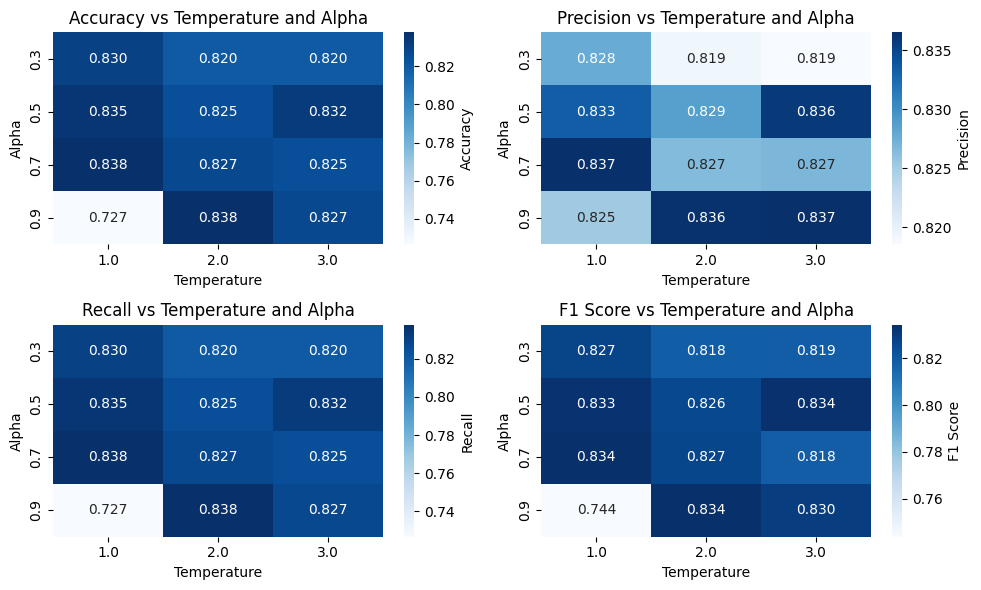

In [38]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Plot Accuracy
plt.subplot(2, 2, 1)
sns.heatmap(df.pivot(index="alpha", columns="temperature", values="accuracy"), annot=True, cmap="Blues", fmt=".3f", cbar_kws={'label': 'Accuracy'})
plt.title("Accuracy vs Temperature and Alpha")
plt.xlabel("Temperature")
plt.ylabel("Alpha")

# Plot Precision
plt.subplot(2, 2, 2)
sns.heatmap(df.pivot(index="alpha", columns="temperature", values="precision"), annot=True, cmap="Blues", fmt=".3f", cbar_kws={'label': 'Precision'})
plt.title("Precision vs Temperature and Alpha")
plt.xlabel("Temperature")
plt.ylabel("Alpha")

# Plot Recall
plt.subplot(2, 2, 3)
sns.heatmap(df.pivot(index="alpha", columns="temperature", values="recall"), annot=True, cmap="Blues", fmt=".3f", cbar_kws={'label': 'Recall'})
plt.title("Recall vs Temperature and Alpha")
plt.xlabel("Temperature")
plt.ylabel("Alpha")

# Plot F1 Score
plt.subplot(2, 2, 4)
sns.heatmap(df.pivot(index="alpha", columns="temperature", values="f1"), annot=True, cmap="Blues", fmt=".3f", cbar_kws={'label': 'F1 Score'})
plt.title("F1 Score vs Temperature and Alpha")
plt.xlabel("Temperature")
plt.ylabel("Alpha")

# Show the plots
plt.tight_layout()
plt.show()


In [41]:
data = [
    {'temperature': 1.0, 'alpha': 0.3, 'accuracy': 0.8298969072164949, 'precision': 0.8277090767909066, 'recall': 0.8298969072164949, 'f1': 0.8272837322500177},
    {'temperature': 1.0, 'alpha': 0.5, 'accuracy': 0.8350515463917526, 'precision': 0.8333853096865418, 'recall': 0.8350515463917526, 'f1': 0.8329165832696697},
    {'temperature': 1.0, 'alpha': 0.7, 'accuracy': 0.8376288659793815, 'precision': 0.83652262516548, 'recall': 0.8376288659793815, 'f1': 0.8341876298292671},
    {'temperature': 1.0, 'alpha': 0.9, 'accuracy': 0.7268041237113402, 'precision': 0.8252335533592452, 'recall': 0.7268041237113402, 'f1': 0.7438818285221023},
    {'temperature': 2.0, 'alpha': 0.3, 'accuracy': 0.8195876288659794, 'precision': 0.8193024880196635, 'recall': 0.8195876288659794, 'f1': 0.8183060526143721},
    {'temperature': 2.0, 'alpha': 0.5, 'accuracy': 0.825, 'precision': 0.829, 'recall': 0.825, 'f1': 0.826},
    {'temperature': 2.0, 'alpha': 0.7, 'accuracy': 0.827, 'precision': 0.827, 'recall': 0.827, 'f1': 0.827},
    {'temperature': 2.0, 'alpha': 0.9, 'accuracy': 0.838, 'precision': 0.836, 'recall': 0.838, 'f1': 0.834},
    {'temperature': 3.0, 'alpha': 0.3, 'accuracy': 0.820, 'precision': 0.819, 'recall': 0.820, 'f1': 0.819},
    {'temperature': 3.0, 'alpha': 0.5, 'accuracy': 0.832, 'precision': 0.836, 'recall': 0.832, 'f1': 0.834},
    {'temperature': 3.0, 'alpha': 0.7, 'accuracy': 0.825, 'precision': 0.827, 'recall': 0.825, 'f1': 0.818},
    {'temperature': 3.0, 'alpha': 0.9, 'accuracy': 0.827, 'precision': 0.837, 'recall': 0.827, 'f1': 0.830},
]

df = pd.DataFrame(data)

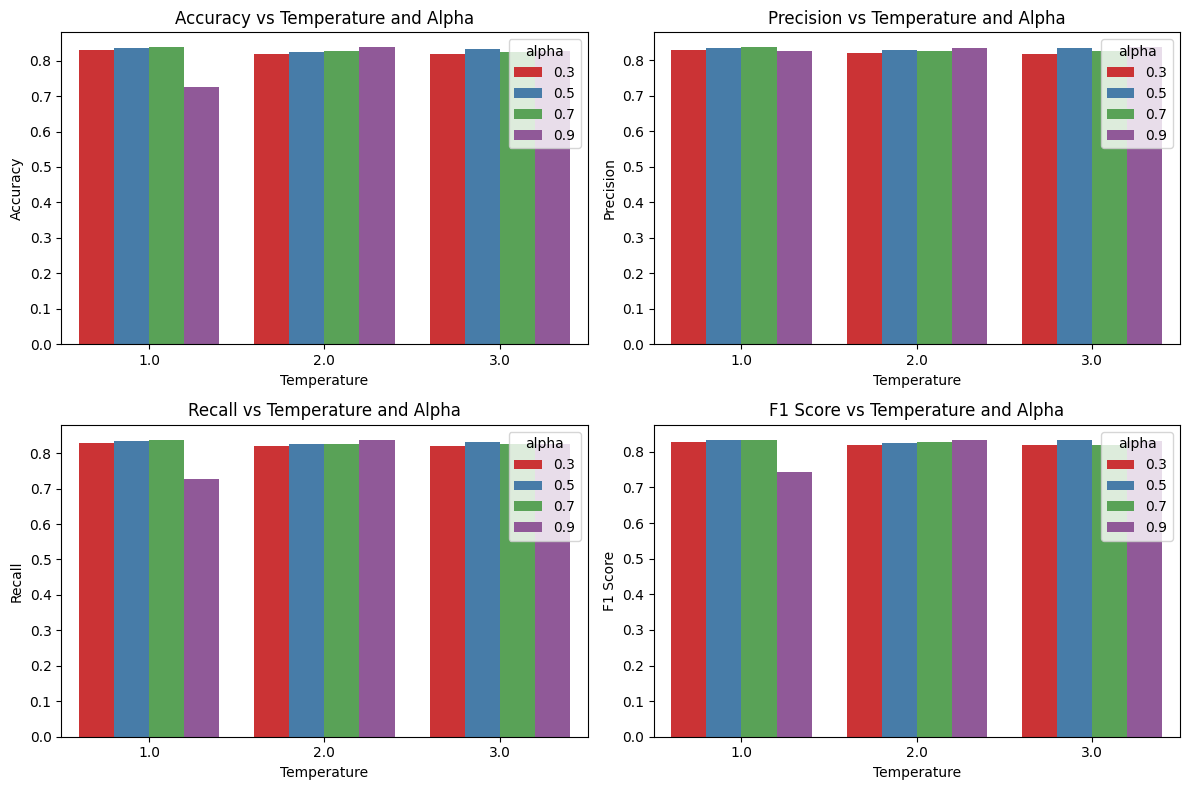

In [44]:
# Set up the figure
plt.figure(figsize=(12, 8))

# Plot Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x="temperature", y="accuracy", hue="alpha", data=df,palette="Set1")
plt.title("Accuracy vs Temperature and Alpha")
plt.xlabel("Temperature")
plt.ylabel("Accuracy")

# Plot Precision
plt.subplot(2, 2, 2)
sns.barplot(x="temperature", y="precision", hue="alpha", data=df,palette="Set1")
plt.title("Precision vs Temperature and Alpha")
plt.xlabel("Temperature")
plt.ylabel("Precision")

# Plot Recall
plt.subplot(2, 2, 3)
sns.barplot(x="temperature", y="recall", hue="alpha", data=df,palette="Set1")
plt.title("Recall vs Temperature and Alpha")
plt.xlabel("Temperature")
plt.ylabel("Recall")

# Plot F1 Score
plt.subplot(2, 2, 4)
sns.barplot(x="temperature", y="f1", hue="alpha", data=df,palette="Set1")
plt.title("F1 Score vs Temperature and Alpha")
plt.xlabel("Temperature")
plt.ylabel("F1 Score")

# Show the plots
plt.tight_layout()
plt.show()

### For gird search, train from strach for consistency

In [45]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_dataset, val_dataset, test_dataset = prepare_datasets(tokenizer)

Map:   0%|          | 0/3488 [00:00<?, ? examples/s]

Map:   0%|          | 0/388 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [46]:
training_args_teacher = TrainingArguments(
    output_dir="/content/results_knowledge_distill/teacher_model_ROBERTA_grid_seach",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="/content/logs_knowledge_distill/teacher_model_ROBERTA_grid_search",
    logging_steps=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    save_total_limit=2,
    load_best_model_at_end=True,
    push_to_hub=False
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [7]:
def distillation_loss(student_logits, teacher_logits, true_labels, temperature, alpha):
    device = student_logits.device
    true_labels = true_labels.to(device)
    teacher_logits = teacher_logits.to(device)

    soft_labels = F.softmax(teacher_logits / temperature, dim=-1)

    hard_loss = F.cross_entropy(student_logits, true_labels)

    soft_loss = F.kl_div(
        F.log_softmax(student_logits / temperature, dim=-1),
        soft_labels,
        reduction="batchmean"
    )

    return alpha * soft_loss + (1 - alpha) * hard_loss

In [7]:
# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to("cuda") for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
            labels = batch["labels"].to("cuda")

            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, axis=-1).cpu().numpy()
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds)

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average="weighted")
    recall = recall_score(true_labels, predictions, average="weighted")
    f1 = f1_score(true_labels, predictions, average="weighted")
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [49]:
# Perform grid search
temperatures = [1.0, 2.0, 3.0]
alphas = [0.3, 0.5, 0.7, 0.9]

In [50]:
best_metrics = {}
best_params = {}

In [51]:
# Start grid search
for temperature in temperatures:
    for alpha in alphas:
        print(f"Training with temperature={temperature}, alpha={alpha}...")

        teacher_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3).to("cuda")
        student_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to("cuda")

        trainer_teacher = Trainer(
            model=teacher_model,
            args=training_args_teacher,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=tokenizer
        )
        trainer_teacher.train()

        teacher_model.save_pretrained(f"/content/checkpoints/teacher_model_ROBERTA_{temperature}_{alpha}")

        train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=16)

        optimizer = Adam(student_model.parameters(), lr=2e-5)

        student_model.train()
        for epoch in range(3):  # training for 3 epochs
            total_loss = 0.0
            for batch in train_dataloader:
                inputs = {k: v.to("cuda") for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
                labels = batch["labels"].to("cuda")

                # Get teacher logits (soft labels)
                with torch.no_grad():
                    teacher_logits = teacher_model(**inputs).logits

                # Get student logits
                student_outputs = student_model(**inputs)
                student_logits = student_outputs.logits

                # Calculate distillation loss
                loss = distillation_loss(student_logits, teacher_logits, labels, temperature, alpha)
                total_loss += loss.item()

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            print(f"Epoch {epoch + 1}/3, Loss: {total_loss / len(train_dataloader)}")

        val_metrics = evaluate_model(student_model, val_dataloader)
        print(f"Validation Metrics: {val_metrics}")

        if best_metrics.get("f1", 0) < val_metrics["f1"]:
            best_metrics = val_metrics
            best_params = {"temperature": temperature, "alpha": alpha}

print(f"Best Hyperparameters: {best_params}")
print(f"Best Metrics: {best_metrics}")

Training with temperature=1.0, alpha=0.3...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-51-5219ad9dabdf>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss
1,0.844600,0.900884
2,0.823600,0.825296
3,0.808400,0.788450


Epoch 1/3, Loss: 0.46957809122603966
Epoch 2/3, Loss: 0.3139647369127755
Epoch 3/3, Loss: 0.26214407780848514
Validation Metrics: {'accuracy': 0.8376288659793815, 'precision': 0.8398862824463537, 'recall': 0.8376288659793815, 'f1': 0.8310263073315738}
Training with temperature=1.0, alpha=0.5...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-51-5219ad9dabdf>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss
1,0.841100,0.879826
2,0.793100,0.803001
3,0.765800,0.790243


Epoch 1/3, Loss: 0.38276030704242375
Epoch 2/3, Loss: 0.27664949922660076
Epoch 3/3, Loss: 0.2400041089965663
Validation Metrics: {'accuracy': 0.8170103092783505, 'precision': 0.837305730113012, 'recall': 0.8170103092783505, 'f1': 0.8050978025712996}
Training with temperature=1.0, alpha=0.7...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-51-5219ad9dabdf>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss
1,0.841100,0.879826
2,0.793100,0.803001
3,0.765800,0.790243


Epoch 1/3, Loss: 0.2780301862763702
Epoch 2/3, Loss: 0.20553818348487582
Epoch 3/3, Loss: 0.1834566878547909
Validation Metrics: {'accuracy': 0.7731958762886598, 'precision': 0.8038614148685745, 'recall': 0.7731958762886598, 'f1': 0.7499013506711274}
Training with temperature=1.0, alpha=0.9...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-51-5219ad9dabdf>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss
1,0.841100,0.879826
2,0.793100,0.803001
3,0.765800,0.790243


Epoch 1/3, Loss: 0.15711717574148004
Epoch 2/3, Loss: 0.10079986070615983
Epoch 3/3, Loss: 0.08658158755220405
Validation Metrics: {'accuracy': 0.7268041237113402, 'precision': 0.7564079141529226, 'recall': 0.7268041237113402, 'f1': 0.679571193818801}
Training with temperature=2.0, alpha=0.3...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-51-5219ad9dabdf>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss
1,0.841100,0.879826
2,0.793100,0.803001
3,0.765800,0.790243


Epoch 1/3, Loss: 0.43246159299251136
Epoch 2/3, Loss: 0.2407882811347826
Epoch 3/3, Loss: 0.17087770762656807
Validation Metrics: {'accuracy': 0.8402061855670103, 'precision': 0.8446246537928913, 'recall': 0.8402061855670103, 'f1': 0.8337970427200434}
Training with temperature=2.0, alpha=0.5...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-51-5219ad9dabdf>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss
1,0.841100,0.879826
2,0.793100,0.803001
3,0.765800,0.790243


Epoch 1/3, Loss: 0.32840735608831456
Epoch 2/3, Loss: 0.20358471411767357
Epoch 3/3, Loss: 0.15899113712644358
Validation Metrics: {'accuracy': 0.8479381443298969, 'precision': 0.8537685309654318, 'recall': 0.8479381443298969, 'f1': 0.8415580370495922}
Training with temperature=2.0, alpha=0.7...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-51-5219ad9dabdf>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss
1,0.841100,0.879826
2,0.793100,0.803001
3,0.765800,0.790243


Epoch 1/3, Loss: 0.21858785745747591
Epoch 2/3, Loss: 0.15075211585798395
Epoch 3/3, Loss: 0.12697655259879356
Validation Metrics: {'accuracy': 0.8427835051546392, 'precision': 0.8565280707269036, 'recall': 0.8427835051546392, 'f1': 0.8344957649991004}
Training with temperature=2.0, alpha=0.9...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-51-5219ad9dabdf>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss
1,0.841100,0.879826
2,0.793100,0.803001
3,0.765800,0.790243


Epoch 1/3, Loss: 0.09844845671787722
Epoch 2/3, Loss: 0.07122124693946007
Epoch 3/3, Loss: 0.06378683687076656
Validation Metrics: {'accuracy': 0.770618556701031, 'precision': 0.79751215618348, 'recall': 0.770618556701031, 'f1': 0.7470662566380434}
Training with temperature=3.0, alpha=0.3...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-51-5219ad9dabdf>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss
1,0.841100,0.879826
2,0.793100,0.803001
3,0.765800,0.790243


Epoch 1/3, Loss: 0.41921555661006804
Epoch 2/3, Loss: 0.21598331165423088
Epoch 3/3, Loss: 0.13979856992875217
Validation Metrics: {'accuracy': 0.8350515463917526, 'precision': 0.839932334589111, 'recall': 0.8350515463917526, 'f1': 0.8276403683666697}
Training with temperature=3.0, alpha=0.5...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-51-5219ad9dabdf>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss
1,0.841100,0.879826
2,0.793100,0.803001
3,0.765800,0.790243


Epoch 1/3, Loss: 0.3105423928605854
Epoch 2/3, Loss: 0.1741138709657783
Epoch 3/3, Loss: 0.12415652197503715
Validation Metrics: {'accuracy': 0.8376288659793815, 'precision': 0.8422299593421195, 'recall': 0.8376288659793815, 'f1': 0.830817962471834}
Training with temperature=3.0, alpha=0.7...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-51-5219ad9dabdf>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss
1,0.841100,0.879826
2,0.793100,0.803001
3,0.765800,0.790243


Epoch 1/3, Loss: 0.19870037500054463
Epoch 2/3, Loss: 0.12368139388774513
Epoch 3/3, Loss: 0.09687098079796778
Validation Metrics: {'accuracy': 0.8530927835051546, 'precision': 0.8584148108106562, 'recall': 0.8530927835051546, 'f1': 0.8474563176496248}
Training with temperature=3.0, alpha=0.9...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-51-5219ad9dabdf>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss
1,0.841100,0.879826
2,0.793100,0.803001
3,0.765800,0.790243


Epoch 1/3, Loss: 0.08095941760944664
Epoch 2/3, Loss: 0.05820950544481977
Epoch 3/3, Loss: 0.0506890488771397
Validation Metrics: {'accuracy': 0.8118556701030928, 'precision': 0.8387543611377265, 'recall': 0.8118556701030928, 'f1': 0.797773794031129}
Best Hyperparameters: {'temperature': 3.0, 'alpha': 0.7}
Best Metrics: {'accuracy': 0.8530927835051546, 'precision': 0.8584148108106562, 'recall': 0.8530927835051546, 'f1': 0.8474563176496248}


In [53]:
data_from_new_training = [
    {'temperature': 1.0, 'alpha': 0.3, 'accuracy': 0.8376288659793815, 'precision': 0.8398862824463537, 'recall': 0.8376288659793815, 'f1': 0.8310263073315738},
    {'temperature': 1.0, 'alpha': 0.5, 'accuracy': 0.8170103092783, 'precision':0.83730573, 'recall':0.8170103, 'f1':0.805097 },
    {'temperature': 1.0, 'alpha': 0.7, 'accuracy': 0.7731958762, 'precision': 0.8038614, 'recall': 0.7731958, 'f1': 0.7499013},
    {'temperature': 1.0, 'alpha': 0.9, 'accuracy': 0.726804123, 'precision': 0.75640791, 'recall': 0.7268041, 'f1': 0.679571193},
    {'temperature': 2.0, 'alpha': 0.3, 'accuracy': 0.84020618, 'precision': 0.84462465, 'recall': 0.84020618, 'f1': 0.833797},
    {'temperature': 2.0, 'alpha': 0.5, 'accuracy': 0.84793814, 'precision': 0.8537685, 'recall': 0.8479381, 'f1': 0.84155},
    {'temperature': 2.0, 'alpha': 0.7, 'accuracy': 0.8427835, 'precision': 0.856528, 'recall': 0.842783, 'f1': 0.834495},
    {'temperature': 2.0, 'alpha': 0.9, 'accuracy': 0.7706185, 'precision': 0.797512, 'recall': 0.770618, 'f1': 0.7470662},
    {'temperature': 3.0, 'alpha': 0.3, 'accuracy': 0.835051, 'precision': 0.8399, 'recall': 0.835051, 'f1': 0.82764},
    {'temperature': 3.0, 'alpha': 0.5, 'accuracy': 0.8376288, 'precision': 0.84222, 'recall': 0.83762, 'f1': 0.830817},
    {'temperature': 3.0, 'alpha': 0.7, 'accuracy': 0.853092, 'precision': 0.858414, 'recall': 0.8530927, 'f1': 0.847456},
    {'temperature': 3.0, 'alpha': 0.9, 'accuracy': 0.8118556, 'precision': 0.838754, 'recall': 0.81185, 'f1': 0.79777},
]

df = pd.DataFrame(data_from_new_training)

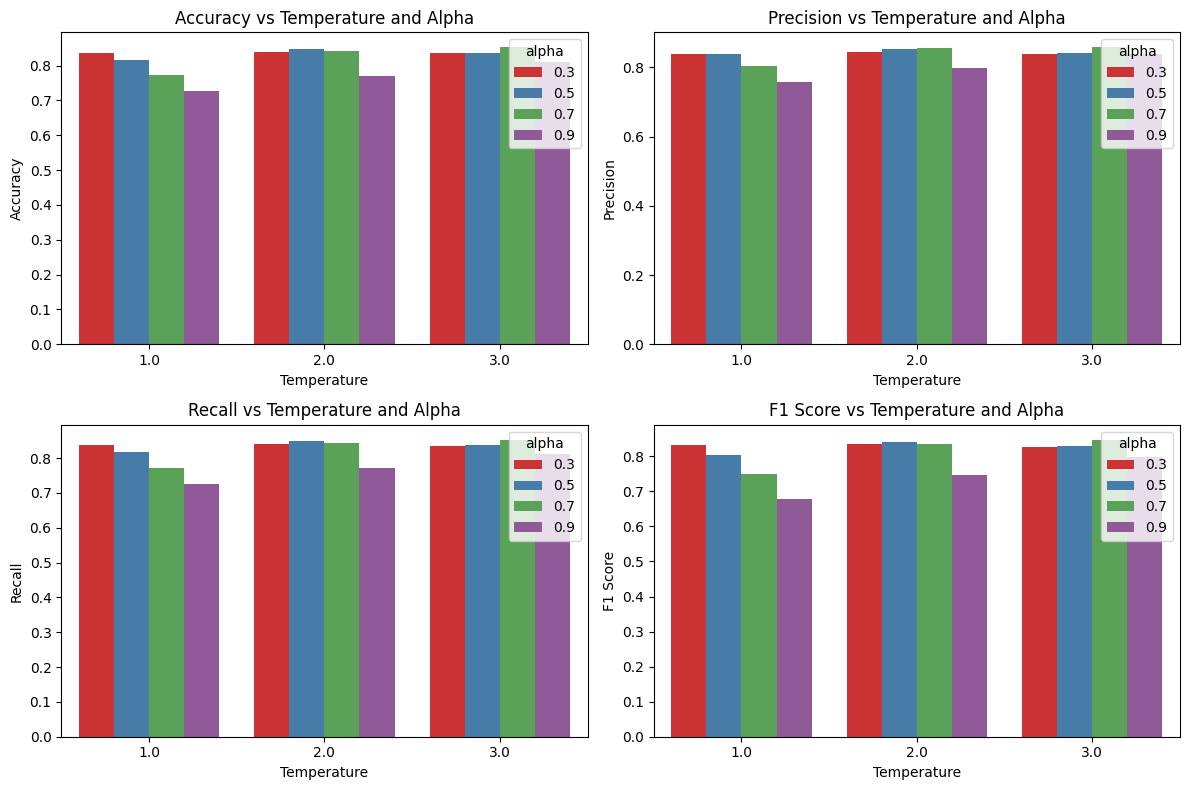

In [54]:
# Set up the figure
plt.figure(figsize=(12, 8))

# Plot Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x="temperature", y="accuracy", hue="alpha", data=df,palette="Set1")
plt.title("Accuracy vs Temperature and Alpha")
plt.xlabel("Temperature")
plt.ylabel("Accuracy")

# Plot Precision
plt.subplot(2, 2, 2)
sns.barplot(x="temperature", y="precision", hue="alpha", data=df,palette="Set1")
plt.title("Precision vs Temperature and Alpha")
plt.xlabel("Temperature")
plt.ylabel("Precision")

# Plot Recall
plt.subplot(2, 2, 3)
sns.barplot(x="temperature", y="recall", hue="alpha", data=df,palette="Set1")
plt.title("Recall vs Temperature and Alpha")
plt.xlabel("Temperature")
plt.ylabel("Recall")

# Plot F1 Score
plt.subplot(2, 2, 4)
sns.barplot(x="temperature", y="f1", hue="alpha", data=df,palette="Set1")
plt.title("F1 Score vs Temperature and Alpha")
plt.xlabel("Temperature")
plt.ylabel("F1 Score")

# Show the plots
plt.tight_layout()
plt.show()



### Training knowledge distillation model with AdamW instead of Adam vis using best hyperparameters from grid search.

In [9]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader

In [10]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_dataset, val_dataset, test_dataset = prepare_datasets(tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3488 [00:00<?, ? examples/s]

Map:   0%|          | 0/388 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [12]:
teacher_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3).to("cuda")
student_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to("cuda")

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args_teacher = TrainingArguments(
    output_dir="/content/teacher_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="/content/logs_teacher",
    logging_steps=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    save_total_limit=2,
    load_best_model_at_end=True,
    push_to_hub=False,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [18]:
import os

os.environ["WANDB_DISABLED"] = "true"

trainer_teacher = Trainer(
    model=teacher_model,
    args=training_args_teacher,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

trainer_teacher.train()

teacher_model.save_pretrained("./teacher_model")
print("Teacher model training completed and saved.")

<ipython-input-18-4ce791a62616>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss
1,0.819600,0.863598
2,0.817700,0.887446
3,0.824100,0.823151


Teacher model training completed and saved.


In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [20]:
optimizer = AdamW(student_model.parameters(), lr=2e-5)

In [21]:
temperature = 3.0
alpha = 0.7
epochs = 3

In [22]:
teacher_model.eval()
for epoch in range(epochs):
    student_model.train()
    total_loss = 0.0

    for batch in train_dataloader:
        inputs = {k: v.to("cuda") for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
        labels = batch["labels"].to("cuda")

        # Get teacher logits (soft labels)
        with torch.no_grad():
            teacher_logits = teacher_model(**inputs).logits

        # Get student logits
        student_outputs = student_model(**inputs)
        student_logits = student_outputs.logits

        # Calculate loss
        loss = distillation_loss(student_logits, teacher_logits, labels, temperature, alpha)
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dataloader)}")

Epoch 1/3, Loss: 0.20505645566987335
Epoch 2/3, Loss: 0.12929951218426775
Epoch 3/3, Loss: 0.10490229590838655


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

val_metrics = evaluate_model(student_model, val_dataloader)
print(f"Validation Metrics with AdamW: {val_metrics}")

Validation Metrics with AdamW: {'accuracy': 0.8402061855670103, 'precision': 0.8423849425605004, 'recall': 0.8402061855670103, 'f1': 0.8354557587007766}


In [25]:
student_model.save_pretrained("/content/student_model")
print("Student model training completed and saved.")

Student model training completed and saved.


### Training with RMSProp

In [27]:
teacher_model = AutoModelForSequenceClassification.from_pretrained("./teacher_model").to("cuda")
teacher_model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [28]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [29]:
student_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to("cuda")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
from torch.optim import RMSprop

lr = 2e-5
weight_decay = 1e-2
optimizer = RMSprop(student_model.parameters(), lr=lr, weight_decay=weight_decay)

In [31]:
epochs = 3
temperature = 3.0
alpha = 0.7

In [32]:
for epoch in range(epochs):
    student_model.train()
    total_loss = 0.0

    for batch in train_dataloader:
        inputs = {k: v.to("cuda") for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
        labels = batch["labels"].to("cuda")

        # Get teacher logits
        with torch.no_grad():
            teacher_logits = teacher_model(**inputs).logits

        # Get student logits
        student_outputs = student_model(**inputs)
        student_logits = student_outputs.logits

        # Calculate distillation loss
        loss = distillation_loss(student_logits, teacher_logits, labels, temperature, alpha)
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dataloader)}")


Epoch 1/3, Loss: 0.20615704227751547
Epoch 2/3, Loss: 0.15681191127097935
Epoch 3/3, Loss: 0.14590958153846068


In [33]:
val_metrics = evaluate_model(student_model, val_dataloader)
print(f"Validation Metrics with RMSProp: {val_metrics}")

Validation Metrics with RMSProp: {'accuracy': 0.8170103092783505, 'precision': 0.8250155837928553, 'recall': 0.8170103092783505, 'f1': 0.8194498555951912}


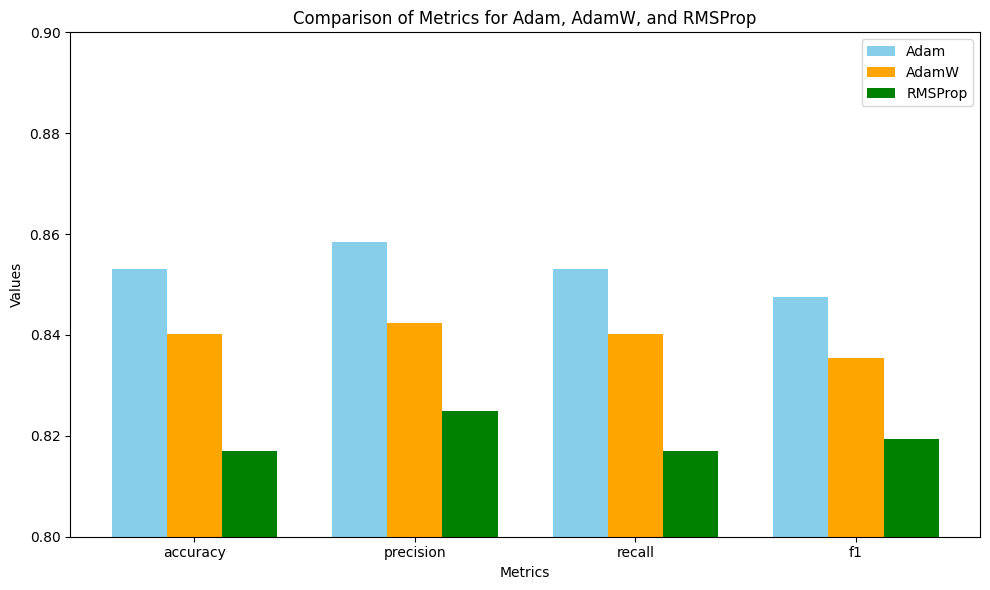

In [37]:
import matplotlib.pyplot as plt
import numpy as np

adam_metrics = {'accuracy': 0.8530927835051546, 'precision': 0.8584148108106562, 'recall': 0.8530927835051546, 'f1': 0.8474563176496248}
adamw_metrics = {'accuracy': 0.8402061855670103, 'precision': 0.8423849425605004, 'recall': 0.8402061855670103, 'f1': 0.8354557587007766}
rmsprop_metrics = {'accuracy': 0.8170103092783505, 'precision': 0.8250155837928553, 'recall': 0.8170103092783505, 'f1': 0.8194498555951912}

labels = list(adam_metrics.keys())
adam_values = list(adam_metrics.values())
adamw_values = list(adamw_metrics.values())
rmsprop_values = list(rmsprop_metrics.values())

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))

# Adam
plt.bar(x - width, adam_values, width, label='Adam', color='skyblue')

# AdamW
plt.bar(x, adamw_values, width, label='AdamW', color='orange')

# RMSProp
plt.bar(x + width, rmsprop_values, width, label='RMSProp', color='green')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Metrics for Adam, AdamW, and RMSProp')
plt.xticks(x, labels)
plt.ylim(0.8, 0.9)

plt.legend()

plt.tight_layout()
plt.show()


In [22]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_dataset, val_dataset, test_dataset = prepare_datasets(tokenizer)

Map:   0%|          | 0/3488 [00:00<?, ? examples/s]

Map:   0%|          | 0/388 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [23]:
teacher_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3).to("cuda")
student_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to("cuda")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
training_args_teacher = TrainingArguments(
    output_dir="/content/teacher_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="/content/logs_teacher",
    logging_steps=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    save_total_limit=2,
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
)

In [27]:
trainer_teacher = Trainer(
    model=teacher_model,
    args=training_args_teacher,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

trainer_teacher.train()
teacher_model.save_pretrained("/content/teacher_model")
print("Teacher model training completed and saved.")

<ipython-input-27-d8957b978b70>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss
1,0.819100,0.872136
2,0.778600,0.798452
3,0.780900,0.775193


Teacher model training completed and saved.


In [28]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch
from torch.optim import Adam
import os

In [29]:
optimizer = torch.optim.Adam(student_model.parameters(), lr=2e-5)

In [30]:
scheduler = CosineAnnealingLR(optimizer, T_max=3)

In [31]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [32]:
teacher_model.eval()
epochs = 3
temperature = 3.0
alpha = 0.7

Epoch 1/3, Loss: 0.22757045890486569
Epoch 2/3, Loss: 0.13817361202261863
Epoch 3/3, Loss: 0.11139411561259437


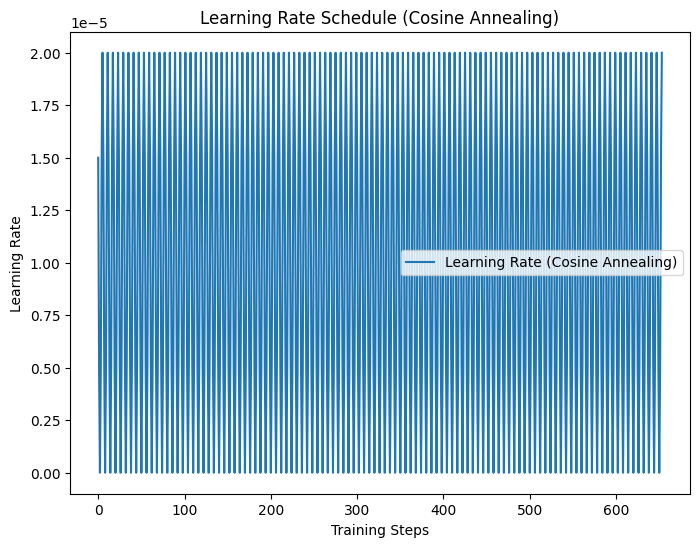

Student model training completed and saved.


In [33]:
import matplotlib.pyplot as plt

lr_values = []
for epoch in range(epochs):
    student_model.train()
    total_loss = 0.0

    for batch in train_dataloader:
        inputs = {k: v.to("cuda") for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
        labels = batch["labels"].to("cuda")

        # Get teacher's logits (soft labels)
        with torch.no_grad():
            teacher_outputs = teacher_model(**inputs)
            teacher_logits = teacher_outputs.logits

        # Get student's logits
        student_outputs = student_model(**inputs)
        student_logits = student_outputs.logits

        # Calculate the distillation loss
        loss = distillation_loss(student_logits, teacher_logits, labels, temperature, alpha)
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step()
        lr_values.append(optimizer.param_groups[0]['lr'])

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dataloader)}")

# Plot the learning rate vs. training step
plt.figure(figsize=(8, 6))
plt.plot(lr_values, label="Learning Rate (Cosine Annealing)")
plt.title("Learning Rate Schedule (Cosine Annealing)")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.legend()
plt.show()

# Save the trained student model
student_model.save_pretrained("/content/student_model_with_teacher_and_cosine_annealing")
print("Student model training completed and saved.")

In [36]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

val_metrics = evaluate_model(student_model, val_dataloader)
print(f"Validation Metrics with Cosine Annealing: {val_metrics}")

Validation Metrics with Cosine Annealing: {'accuracy': 0.8324742268041238, 'precision': 0.8307641957126493, 'recall': 0.8324742268041238, 'f1': 0.8304944620333393}


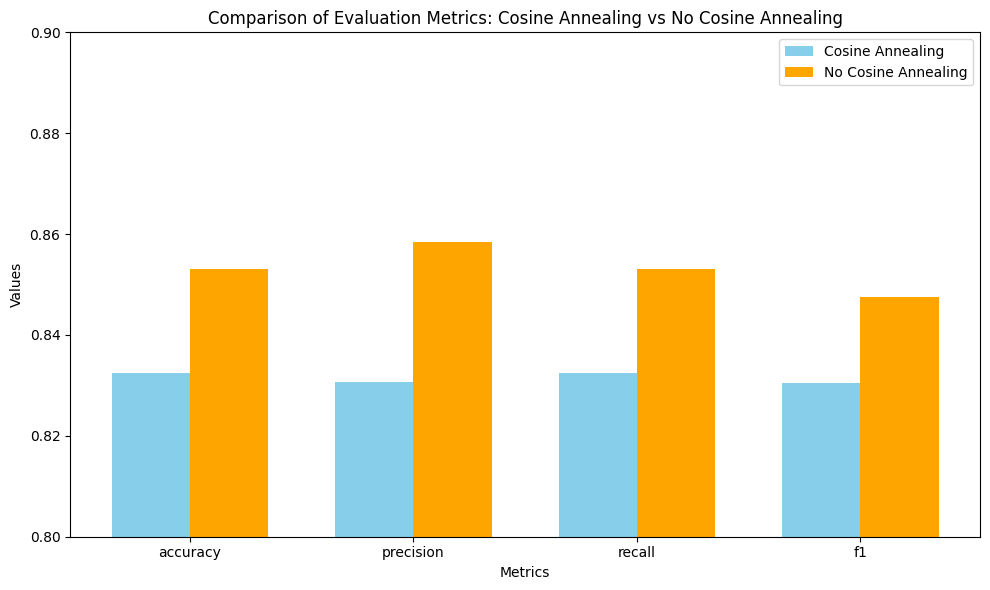

In [38]:
import matplotlib.pyplot as plt
import numpy as np

cosine_annealing_metrics = {
    'accuracy': 0.8324742268041238,
    'precision': 0.8307641957126493,
    'recall': 0.8324742268041238,
    'f1': 0.8304944620333393
}

no_cosine_annealing_metrics = {
    'accuracy': 0.8530927835051546,
    'precision': 0.8584148108106562,
    'recall': 0.8530927835051546,
    'f1': 0.8474563176496248
}

labels = list(cosine_annealing_metrics.keys())

cosine_annealing_values = list(cosine_annealing_metrics.values())
no_cosine_annealing_values = list(no_cosine_annealing_metrics.values())

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x - width/2, cosine_annealing_values, width, label='Cosine Annealing', color='skyblue')
plt.bar(x + width/2, no_cosine_annealing_values, width, label='No Cosine Annealing', color='orange')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Evaluation Metrics: Cosine Annealing vs No Cosine Annealing')
plt.xticks(x, labels)
plt.ylim(0.8, 0.9)

plt.legend()

plt.tight_layout()

plt.show()


<ipython-input-44-c07633f50181>:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(models))  # Use a colormap to get distinct colors
<ipython-input-44-c07633f50181>:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha="right")
<ipython-input-44-c07633f50181>:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha="right")
<ipython-input-44-c07633f50181>:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha="right")
<ip

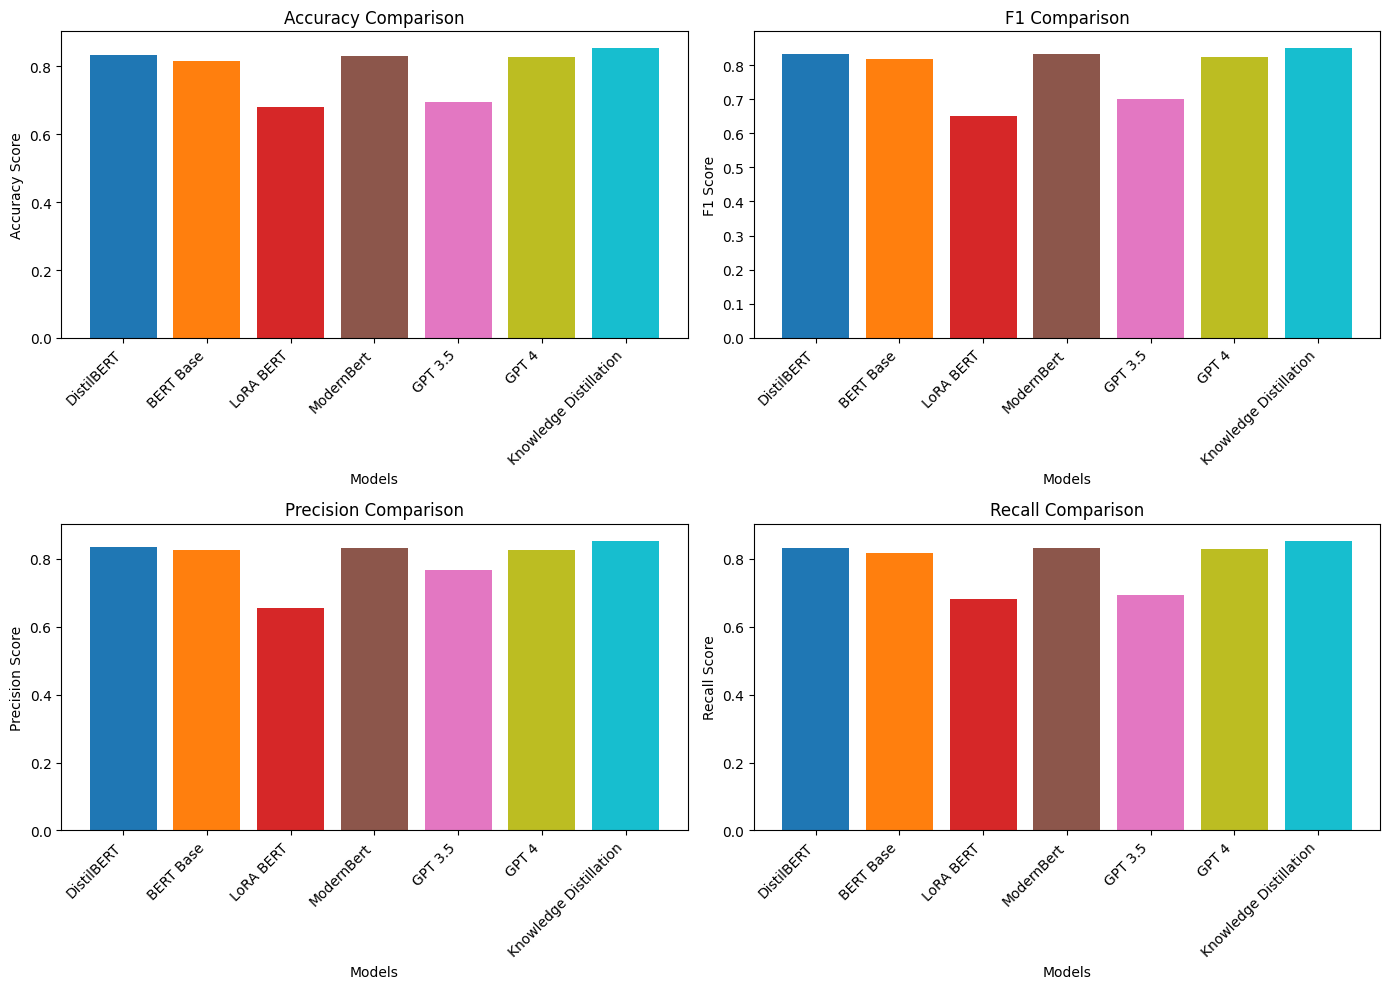

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for each model
metrics = {
    'DistilBERT': {'accuracy': 0.832268, 'f1': 0.832058, 'precision': 0.834176, 'recall': 0.832268},
    'BERT Base': {'accuracy': 0.816495, 'f1': 0.818883, 'precision': 0.825575, 'recall': 0.816495},
    'LoRA BERT': {'accuracy': 0.680412, 'f1': 0.650444, 'precision': 0.655943, 'recall': 0.680412},
    'ModernBert': {'accuracy': 0.831237, 'f1': 0.831361, 'precision': 0.832849, 'recall': 0.831237},
    'GPT 3.5': {'accuracy': 0.693814, 'f1': 0.699329, 'precision': 0.768728, 'recall': 0.693814},
    'GPT 4': {'accuracy': 0.827835, 'f1': 0.824299, 'precision': 0.826397, 'recall': 0.827835},
    'Knowledge Distillation': {'accuracy': 0.8530927835051546, 'f1': 0.8488220784681562,
                               'precision': 0.8533877790196023, 'recall': 0.8530927835051546}
}

labels = list(metrics['DistilBERT'].keys())
models = list(metrics.keys())

values = {metric: [] for metric in labels}
for model in models:
    for metric in labels:
        values[metric].append(metrics[model][metric])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = plt.cm.get_cmap('tab10', len(models))
color_list = [colors(i) for i in range(len(models))]

for i, metric in enumerate(labels):
    ax = axes[i//2, i%2]
    ax.bar(models, values[metric], color=color_list)
    ax.set_title(f'{metric.capitalize()} Comparison')
    ax.set_xlabel('Models')
    ax.set_ylabel(f'{metric.capitalize()} Score')

    y_max = max(values[metric])
    ax.set_ylim(0, y_max + 0.05)

    ax.set_xticklabels(models, rotation=45, ha="right")

plt.tight_layout()

plt.show()
